<a href="https://colab.research.google.com/github/ShawnBrody/Qualifying-Offer-Classifier/blob/master/QO%20Classifier%20(Pitchers).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title In order to start building a model, we must pull in our data from GitHub
! wget https://raw.githubusercontent.com/ShawnBrody/Qualifying-Offer-Classifier/master/Pitchers.csv

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, f1_score
import seaborn as sn

Pitchers = pd.read_csv("Pitchers.csv")

--2019-12-14 05:37:53--  https://raw.githubusercontent.com/ShawnBrody/Qualifying-Offer-Classifier/master/Pitchers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19922 (19K) [text/plain]
Saving to: ‘Pitchers.csv’

Pitchers.csv        100%[===================>]  19.46K  --.-KB/s    in 0.004s  

2019-12-14 05:37:58 (4.93 MB/s) - ‘Pitchers.csv’ saved [19922/19922]



In [0]:
#@title And peek at the hitters data that comes in:
print(Pitchers.head())

              Player  Age  Year  playerID  ...  RA9-WAR  Dollars  QOAmount  QO
0      Andy Pettitte   40  2012       840  ...      2.1      9.4  13300000   0
1      Bartolo Colon   39  2012       375  ...      3.3     16.8  13300000   0
2   Brandon McCarthy   28  2012      4662  ...      2.5     12.3  13300000   0
3  Carlos Villanueva   28  2012      4138  ...      1.6      3.7  13300000   0
4        Chad Durbin   34  2012      1442  ...      0.4     -4.6  13300000   0

[5 rows x 23 columns]


With 23 columns in the design matrix, it made sense to do a little downsizing in dimensions. This was done through theoretical dimension reduction (which columns made sense, and for what reason). Age, TBF, Dollars, Salary, G, RA9-WAR, GS, and SV were chosen for theoretical reasons (they put forth necessary information to capture current production and past pay). An explanation of each variable follows:

* Age – Official age of player
* TBF – Total Batters Faced
* Dollars – $/fWAR (value created)
* Salary – Actual salary
* G – Games appeared in
* RA9-WAR – Wins Above Replacement (FG)
* GS – Games Started
* SV – Saves Recorded

The main desire to include GS and SV was to provide metrics that helped differentiate between starting pitchers and relief pitchers. These two interact well to do just that. There is merit to the idea that SP and RP should be broken out into seperate model building processes, but for now the best option is to stick with just a pitcher model building process that complements the hitter model building process.

In [0]:
#@title Create Design matrix
# Creates dataframes for design matrix and output variable
Pit_Y = Pitchers.iloc[:,-1] # Creates Y variable based on final column
Pit_X = Pitchers[['Age', 'TBF', 'Dollars', 'Salary', 'G', 'RA9-WAR', 'GS', 'SV']] # Uses most important cols to create design matrix

## Optional way to create Pitcher design matrix that helps see importance of variables
# Pit_X = Pitcher.iloc[:,1:25]
# Pit_X = Pit_X.drop('FRM', axis=1)

# Outputs shape of design matrix
print("Number of rows: {0}".format(Pit_X.shape[0]))
print("Number of columns: {0}".format(Pit_X.shape[1]))

Number of rows: 193
Number of columns: 8


In [0]:
#@title Description of the design matrix:
print(Pit_X.head())

   Age  TBF  Dollars   Salary   G  RA9-WAR  GS  SV
0   40  303      9.4  2500000  12      2.1  12   0
1   39  636     16.8  2000000  24      3.3  24   0
2   28  469     12.3  4275000  18      2.5  18   0
3   28  521      3.7  2277500  38      1.6  16   0
4   34  257     -4.6   900000  76      0.4   0   1


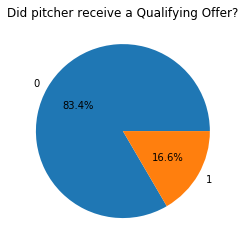

In [0]:
#@title Here we can see the class imbalance at play:
(Pit_Y.value_counts()/Pit_Y.shape[0]).plot(kind='pie', label='', title='Did pitcher receive a Qualifying Offer?', autopct='%1.1f%%').get_figure().savefig('pitimb.png')

In [0]:
#@title Describe Class Imbalance and train/test split
### Because we have a smaller dataset and class imbalance, we need to
### up-sample before we train our models

# Doing both of the above, we create our train/test split
Pit_trainX_orig, Pit_testX, Pit_trainY_orig, Pit_testY = train_test_split(Pit_X,
                                         Pit_Y, 
                                         #stratify = Hit_Y,
                                         test_size = 0.2, 
                                         random_state = 42)

print("Full dataset")
print("0:  {0}".format((Pitchers.iloc[:,-1]==0).sum()))
print("1:  {0}".format(Pitchers.iloc[:,-1].sum()))
print()
print("Validation set")
print("0:  {0}".format((Pit_testY==0).sum()))
print("1:  {0}".format(Pit_testY.sum()))

Full dataset
0:  161
1:  32

Validation set
0:  36
1:  3


Synthetic Minority Over-sampling Technique (SMOTE) can help us take care of our class imbalance problem by over-sampling the minority class. Here we can see the package and function call required to use SMOTE. What will come out is training data that is synthetically balanced:

In [0]:
%%capture
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42, ratio=1.0)
Pit_trainX, Pit_trainY = sm.fit_sample(Pit_trainX_orig, Pit_trainY_orig)

In [0]:
#@title SMOTE in practice

# Shows imbalance maintained even with train/test splits, thanks to stratifying
print("Training set before SMOTE")
print("0:  {0}".format((Pit_trainY_orig==0).sum()))
print("1:  {0}".format(Pit_trainY_orig.sum()))
print()
print("Training Set after SMOTE")
print("0:  {0}".format((Pit_trainY==0).sum()))
print("1:  {0}".format(Pit_trainY.sum()))

Training set before SMOTE
0:  125
1:  29

Training Set after SMOTE
0:  125
1:  125


My first attempt at creating a classifier will start with a RandomForest. Using the following parameters, I used sklearn's GridSearchCV function to find optimal hyperparameters:

*   n_estimators (100, 300, 500, 800, 1000)
*   criterion (gini, entropy)
*   max_depth (5, 10, 15)

For a scoring metric I chose f1 score, because of the presence of class imbalance.

In [0]:
%%capture
# Creates and stores Random Forest object
rf = RandomForestClassifier(random_state=0, class_weight=None)

# Sets up a parameter grid to tune hyperparameters
# bootstrap and max_features are left alone, because they never changed
rf_grid_param = {
    'n_estimators': [100, 300, 500, 800, 1000],
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15]
}

# Puts gridsearch together (takes about 3 minutes to run)
# f1_weighted is better scoring choice because of data imbalance, however SMOTE
# takes care of this imbalance, so we can just use f1 as our scoring metric
rfGridSearch = GridSearchCV(rf, param_grid=rf_grid_param, scoring='f1', cv=3, n_jobs=-1)

# Now we fit the training data to our gridsearch object
rfGridSearch.fit(Pit_trainX, Pit_trainY.ravel())

In [0]:
#@title Next, we seek to choose the best parameters from GridSearchCV
# Now we want to isolate the parameters 
# with the highest f1_weighted score on the train data
print("Best Parameters: {0} \n".format(rfGridSearch.best_params_))


Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 300} 



In [0]:
#@title We then fit the validation set to those specifications. Here are the results:
# These now become our estimator parameters
# Now our model is ready to be introduced to our test data
# proba is better than deterministic for roc_auc
rf_best_grid = rfGridSearch.best_estimator_
rf_test_score = f1_score(Pit_testY, rf_best_grid.predict(Pit_testX), average='weighted')
rf_grid_roc_auc = roc_auc_score(Pit_testY, rf_best_grid.predict_proba(Pit_testX)[:,1])

print("Classification Report:\n{0}".format(classification_report(Pit_testY, rf_best_grid.predict(Pit_testX))))
# print("Our best train f1 score is: {0}".format(round(rfGridSearch.best_score_, 4)))
print("Our test f1 score is: {0}".format(round(rf_test_score, 4)))
print("Our test roc_auc score is: {0}".format(round(rf_grid_roc_auc, 4)))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.86      0.91        36
           1       0.29      0.67      0.40         3

    accuracy                           0.85        39
   macro avg       0.63      0.76      0.66        39
weighted avg       0.92      0.85      0.87        39

Our test f1 score is: 0.8724
Our test roc_auc score is: 0.9352


In [0]:
#@title Just to get an idea of what columns told us the most, we can also look at Feature Importance
# Creates a pseudo table of feature importances
# (Changing the design matrix at the top will show feature importances for whole dataset)
rf_dict_vals = pd.Series(data=rf_best_grid.feature_importances_,index=Pit_trainX_orig.columns)
print("Feature Importances:\n{0}".format(rf_dict_vals.sort_values(ascending=False)))

Feature Importances:
Dollars    0.233448
RA9-WAR    0.215573
Salary     0.126674
TBF        0.118990
GS         0.106790
Age        0.092681
G          0.062222
SV         0.043622
dtype: float64


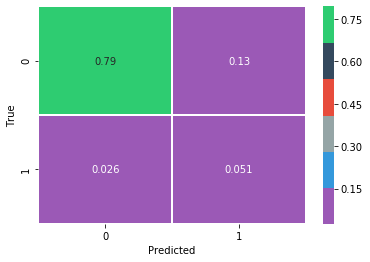

In [0]:
#@title Finally, we look at the confusion matrix to see how our model performed on the validation set
# Class predictions for test data
rf_predictions = rf_best_grid.predict(Pit_testX)

# Confusion matrix for test data
conf_mat_rf = confusion_matrix(Pit_testY, rf_predictions)/Pit_testY.shape[0]

# Plotted Confusion matrix for test data
rf_df_cm = pd.DataFrame(conf_mat_rf, index = [i for i in [0,1]],
                  columns = [i for i in [0,1]])
sn.heatmap(rf_df_cm, annot=True, linewidths=0.5, cmap=sn.color_palette(["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"])).set(xlabel="Predicted", ylabel="True")
print()

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       161
           1       0.86      0.97      0.91        32

    accuracy                           0.97       193
   macro avg       0.93      0.97      0.95       193
weighted avg       0.97      0.97      0.97       193

Our overall f1 score is: 0.9696
Our overall roc_auc score is: 0.9955


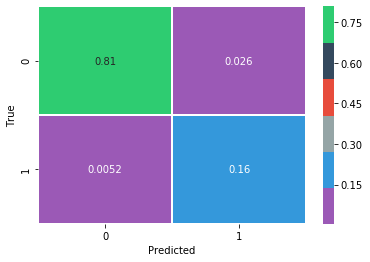

In [0]:
#@title And to get an understanding of how the model performs on the entire dataset:
# Predictions for full dataset
rf_pred_full = rf_best_grid.predict(Pit_X)

# Confusion matrix for full dataset
conf_mat_rf_full = confusion_matrix(Pit_Y, rf_pred_full)/Pit_Y.shape[0]

# Plotted Confusion matrix for full dataset
rf_df_cm_full = pd.DataFrame(conf_mat_rf_full, index = [i for i in [0,1]],
                  columns = [i for i in [0,1]])
sn.heatmap(rf_df_cm_full, annot=True, linewidths=0.5, cmap=sn.color_palette(["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"])).set(xlabel="Predicted", ylabel="True")

rf_ovr_f1 = f1_score(Pit_Y, rf_best_grid.predict(Pit_X), average='weighted')
rf_ovr_roc_auc = roc_auc_score(Pit_Y, rf_best_grid.predict_proba(Pit_X)[:,1])

print("Classification Report:\n{0}".format(classification_report(Pit_Y, rf_best_grid.predict(Pit_X))))
print("Our overall f1 score is: {0}".format(round(rf_ovr_f1, 4)))
print("Our overall roc_auc score is: {0}".format(round(rf_ovr_roc_auc, 4)))

In [0]:
#@title An interesting thing we can do here is all the players who ended up misclassified. Here are those specific players:
# Who were the ones that fell through the cracks?
da = pd.DataFrame(rf_best_grid.predict(Pit_X)==Pit_Y)
print(Pitchers.iloc[da.loc[da['QO']==False].index,0:3])

             Player  Age  Year
5         Dan Haren   31  2012
98      Colby Lewis   35  2015
112    Mike Pelfrey   31  2015
146  Andrew Cashner   30  2017
155    Greg Holland   31  2017
158    Jason Vargas   34  2017


My second attempt at creating a classifier will start with a Logistic Regression. Using the following parameters, I used sklearn's GridSearchCV function to find optimal hyperparameters:

*   C (np.logspace(-4, 4, 20))
*   class_weight (None, balanced)
*   penalty (l1, l2)

For a scoring metric I chose f1 score, because of the presence of class imbalance.

In [0]:
%%capture
from sklearn.linear_model import LogisticRegression

# Creates and stores Random Forest object
logr = LogisticRegression()

# Sets up a parameter grid to tune hyperparameters
# bootstrap and max_features are left alone, because they never changed
logr_grid_param = {
    'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 20),
    'class_weight': [None, 'balanced'] 
}

# Puts gridsearch together
# f1_weighted is better scoring choice because of data imbalance, however SMOTE
# takes care of this imbalance, so we can just use f1 as our scoring metric
logrGridSearch = GridSearchCV(logr, param_grid=logr_grid_param, scoring='f1', cv=3, n_jobs=-1)

# Now we fit the training data to our gridsearch object
logrGridSearch.fit(Pit_trainX, Pit_trainY.ravel())

In [0]:
#@title Next, we seek to choose the best parameters from GridSearchCV
# Now we want to isolate the parameters 
# with the highest f1_weighted score on the train data
print("Best Parameters: {0} \n".format(logrGridSearch.best_params_))

Best Parameters: {'C': 78.47599703514607, 'class_weight': 'balanced', 'penalty': 'l1'} 



In [0]:
#@title We then fit the validation set to those specifications. Here are the results:
# These now become our estimator parameters
# Now our model is ready to be introduced to our test data
# proba is better than deterministic for roc_auc
logr_best_grid = logrGridSearch.best_estimator_
logr_test_score = f1_score(Pit_testY, logr_best_grid.predict(Pit_testX), average='weighted')
logr_grid_roc_auc = roc_auc_score(Pit_testY, logr_best_grid.predict_proba(Pit_testX)[:,1])

print("Classification Report:\n{0}".format(classification_report(Pit_testY, logr_best_grid.predict(Pit_testX))))
print("Our test f1 score is: {0}".format(round(logr_test_score, 4)))
print("Our test roc_auc score is: {0}".format(round(logr_grid_roc_auc, 4)))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        36
           1       0.33      1.00      0.50         3

    accuracy                           0.85        39
   macro avg       0.67      0.92      0.70        39
weighted avg       0.95      0.85      0.88        39

Our test f1 score is: 0.8776
Our test roc_auc score is: 0.9907


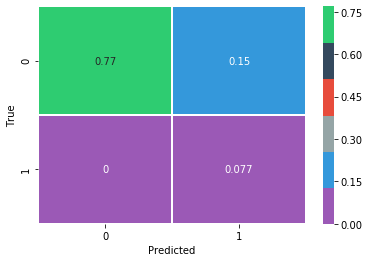

In [0]:
#@title Finally, we look at the confusion matrix to see how our model performed on the validation set
# Class predictions for test data
logr_predictions = logr_best_grid.predict(Pit_testX)

# Confusion matrix for test data
conf_mat_logr = confusion_matrix(Pit_testY, logr_predictions)/Pit_testY.shape[0]

# Plotted Confusion matrix for test data
logr_df_cm = pd.DataFrame(conf_mat_logr, index = [i for i in [0,1]],
                  columns = [i for i in [0,1]])
sn.heatmap(logr_df_cm, annot=True, linewidths=0.5, cmap=sn.color_palette(["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"])).set(xlabel="Predicted", ylabel="True")
print()

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.86      0.92       161
           1       0.57      0.91      0.70        32

    accuracy                           0.87       193
   macro avg       0.77      0.88      0.81       193
weighted avg       0.91      0.87      0.88       193

Our overall f1 score is: 0.8812
Our overall roc_auc score is: 0.9682


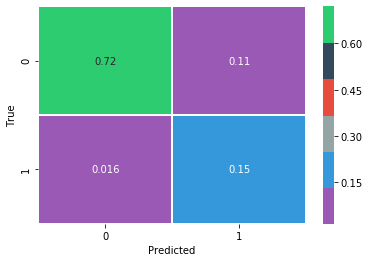

In [0]:
#@title And to get an understanding of how the model performs on the entire dataset:
# Predictions for full dataset
logr_pred_full = logr_best_grid.predict(Pit_X)

# Confusion matrix for full dataset
conf_mat_logr_full = confusion_matrix(Pit_Y, logr_pred_full)/Pit_Y.shape[0]

# Plotted Confusion matrix for full dataset
logr_df_cm_full = pd.DataFrame(conf_mat_logr_full, index = [i for i in [0,1]],
                  columns = [i for i in [0,1]])
sn.heatmap(logr_df_cm_full, annot=True, linewidths=0.5, cmap=sn.color_palette(["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"])).set(xlabel="Predicted", ylabel="True")

logr_ovr_f1 = f1_score(Pit_Y, logr_best_grid.predict(Pit_X), average='weighted')
logr_ovr_roc_auc = roc_auc_score(Pit_Y, logr_best_grid.predict_proba(Pit_X)[:,1])

print("Classification Report:\n{0}".format(classification_report(Pit_Y, logr_best_grid.predict(Pit_X))))
print("Our overall f1 score is: {0}".format(round(logr_ovr_f1, 4)))
print("Our overall roc_auc score is: {0}".format(round(logr_ovr_roc_auc, 4)))

My final attempt at creating a classifier will be a Gaussian Naive Bayes. I used sklearn's GridSearchCV function, however one of the benefits of GNB is that it works rather effectively OOTB. Therefore, there are no hyperparameters to tune here.

For a scoring metric I chose f1 score, because of the presence of class imbalance.

In [0]:
%%capture
from sklearn.naive_bayes import GaussianNB

# Creates and stores Gaussian Naive Bayes object
gnb = GaussianNB()

# Sets up a parameter grid to tune hyperparameters
# bootstrap and max_features are left alone, because they never changed

gnb_grid_param = {

}


# Puts gridsearch together
# f1_weighted is better scoring choice because of data imbalance, however SMOTE
# takes care of this imbalance, so we can just use f1 as our scoring metric
gnbGridSearch = GridSearchCV(gnb, param_grid=gnb_grid_param, scoring='f1', cv=3, n_jobs=-1,)

# Now we fit the training data to our gridsearch object
gnbGridSearch.fit(Pit_trainX, Pit_trainY.ravel())

In [0]:
#@title We then fit the validation set to those specifications. Here are the results:

# These now become our estimator parameters
# Now our model is ready to be introduced to our test data
# proba is better than deterministic for roc_auc
gnb_best_grid = gnbGridSearch.best_estimator_
gnb_test_score = f1_score(Pit_testY, gnb_best_grid.predict(Pit_testX), average='weighted')
gnb_grid_roc_auc = roc_auc_score(Pit_testY, gnb_best_grid.predict_proba(Pit_testX)[:,1])

print("Classification Report:\n{0}".format(classification_report(Pit_testY, gnb_best_grid.predict(Pit_testX))))
print("Our test f1 score is: {0}".format(round(gnb_test_score, 4)))
print("Our test roc_auc score is: {0}".format(round(gnb_grid_roc_auc, 4)))

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.72      0.83        36
           1       0.17      0.67      0.27         3

    accuracy                           0.72        39
   macro avg       0.56      0.69      0.55        39
weighted avg       0.90      0.72      0.78        39

Our test f1 score is: 0.7824
Our test roc_auc score is: 0.7685


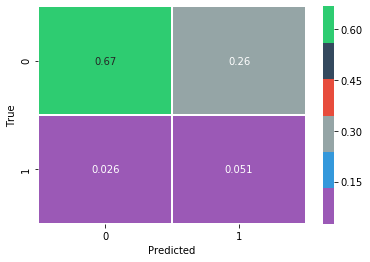

In [0]:
#@title Finally, we look at the confusion matrix to see how our model performed on the validation set
# Class predictions for test data
gnb_predictions = gnb_best_grid.predict(Pit_testX)

# Confusion matrix for test data
conf_mat_gnb = confusion_matrix(Pit_testY, gnb_predictions)/Pit_testY.shape[0]

# Plotted Confusion matrix for test data
gnb_df_cm = pd.DataFrame(conf_mat_gnb, index = [i for i in [0,1]],
                  columns = [i for i in [0,1]])
sn.heatmap(gnb_df_cm, annot=True, linewidths=0.5, cmap=sn.color_palette(["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"])).set(xlabel="Predicted", ylabel="True")
print()

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.76      0.84       161
           1       0.39      0.75      0.51        32

    accuracy                           0.76       193
   macro avg       0.66      0.76      0.68       193
weighted avg       0.85      0.76      0.79       193

Our overall f1 score is: 0.7874
Our overall roc_auc score is: 0.8488


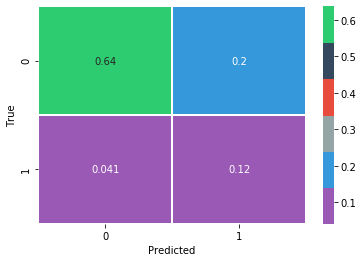

In [0]:
#@title And to get an understanding of how the model performs on the entire dataset:
# Predictions for full dataset
gnb_pred_full = gnb_best_grid.predict(Pit_X)

# Confusion matrix for full dataset
conf_mat_gnb_full = confusion_matrix(Pit_Y, gnb_pred_full)/Pit_Y.shape[0]

# Plotted Confusion matrix for full dataset
gnb_df_cm_full = pd.DataFrame(conf_mat_gnb_full, index = [i for i in [0,1]],
                  columns = [i for i in [0,1]])
sn.heatmap(gnb_df_cm_full, annot=True, linewidths=0.5, cmap=sn.color_palette(["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"])).set(xlabel="Predicted", ylabel="True")

gnb_ovr_f1 = f1_score(Pit_Y, gnb_best_grid.predict(Pit_X), average='weighted')
gnb_ovr_roc_auc = roc_auc_score(Pit_Y, gnb_best_grid.predict_proba(Pit_X)[:,1])

print("Classification Report:\n{0}".format(classification_report(Pit_Y, gnb_best_grid.predict(Pit_X))))
print("Our overall f1 score is: {0}".format(round(gnb_ovr_f1, 4)))
print("Our overall roc_auc score is: {0}".format(round(gnb_ovr_roc_auc, 4)))

# Conclusions

Of the three models built, the Random Forest and Logistic Regression seem to have performed equally well. On the validation set, both performed similarly and miss the same rows. However, reapplying both on the full set, the Random Forest model comes out with a better `f1` and `ROC_AUC` score. In general, both models perform well and new data would help better understand which model works better.

To solve this issue, as with the hitter models, I could apply data from the 2019 season to both models and see how the testing metrics change. Overall, I feel confident that both models work in the ways I hoped they would. Both, and the Random Forest in particular, don't have the many misclassifications of players that received a QO when they were predicted not to. This can be particulary useful, as it can help players and agents more accurately predict when they are about to receive a QO offer with enough lead-time to act accordingly.